<a href="https://colab.research.google.com/github/nupursjsu/Machine-Learning/blob/master/ML_Final_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Political Affiliation Factor**

**Political Affiliation** means closeness to or supporting a particular political party.

It is a very important factor in determining if a news or statement is fake because party members usually stick to the party's philosophy and any digression from that is a good approximator of fakenews. So, I have tried to model this factor to check the credibility of news.

# **Initial Dataset : Liar Liar**

## **Loading Liar Dataset**

In [0]:
#Importing necessary libraries
import warnings
warnings.filterwarnings("ignore")

!pip install nltk
!pip install gensim
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import numpy as np
import pandas as pd
import nltk
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
# sklearn libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.manifold import TSNE
from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from nltk.stem.porter import *
from sklearn import metrics
import pickle
from fastai import *
from fastai.tabular import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
pd.set_option('display.max_colwidth', -1)
np.random.seed(1)

In [0]:
# Read data file into colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Defining link to the liar dataset
link = 'https://drive.google.com/open?id=1Gw5NhXqsnWJnQURLkjnvhcmk5ExTB89X'
fluff, id = link.split('=')

#downloading the zip file
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('liar_dataset.zip')

import zipfile
with zipfile.ZipFile('liar_dataset.zip', 'r') as zip_ref:

    zip_ref.extractall()

#Getting the train data
liar_train = pd.read_csv('train.tsv', sep='\t',header=None)
liar_train=liar_train.drop(columns=[0])

#Getting the test data
liar_test = pd.read_csv('test.tsv', sep='\t',header=None)
liar_test=liar_test.drop(columns=[0])

In [0]:
#Adding columns to liar dataset
columns=[
'label',
'statement',
'subject',
'speaker',
'speaker_job_title',
'state_info',
'affiliation',
'barely_true_counts',
'false_counts',
'half_true_counts',
'mostly_true_counts',
'pants_on_fire_counts',
'context'
]


liar_train.columns=columns
liar_test.columns=columns

In [0]:
#Combining train and test datasets
liar=pd.concat([liar_train,liar_test])
liar.head(2)

,label,statement,subject,speaker,speaker_job_title,state_info,affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,half-true,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


## **Cleaning liar dataset**

Cleaning the dataset includes: 
Stopwords removal, stemming, lemmatization, converting to lowercase, removing punctuations, special characters and digits, and word tokenization

In [0]:
#Defining stop words for removal
stop_words = set(stopwords.words('english'))

#Removing punctations ,special characters and digits.
#Converting all the text to lower case and then work_tokenizing them and storing it in a column called CleanStatement

liar.dropna()
liar['CleanStatement'] = liar['statement'].map(lambda x: re.sub(r"\W", " ",str(x)))
liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: re.sub(r'[,\.!?]', " ",str(x)))
liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: re.sub(r" \d+", " ",str(x)))
liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: word_tokenize(x.lower()))

liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: ' '.join(x))
liar['CleanStatement'] = liar['CleanStatement'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

liar.head(2)

,label,statement,subject,speaker,speaker_job_title,state_info,affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,CleanStatement
0,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,says annies list political group supports third trimester abortions demand
1,half-true,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,decline coal start started natural gas took started begin president george w bushs administration


## **Exploring Liar Liar dataset**

Let's start with plotting the Pearson Correlation plot for the above dataset to see what features are impacting "Political Affiliation" factor.

In [0]:
#Converting categorical columns to numeric
le=LabelEncoder()
num_liar = liar.copy()
num_liar['label']= le.fit_transform(num_liar['label'].astype(str))
num_liar['speaker']=le.fit_transform(num_liar['speaker'].astype(str))
num_liar['speaker_job_title']=le.fit_transform(num_liar['speaker_job_title'].astype(str))
num_liar['state_info']=le.fit_transform(num_liar['state_info'].astype(str))
num_liar['affiliation']=le.fit_transform(num_liar['affiliation'].astype(str))

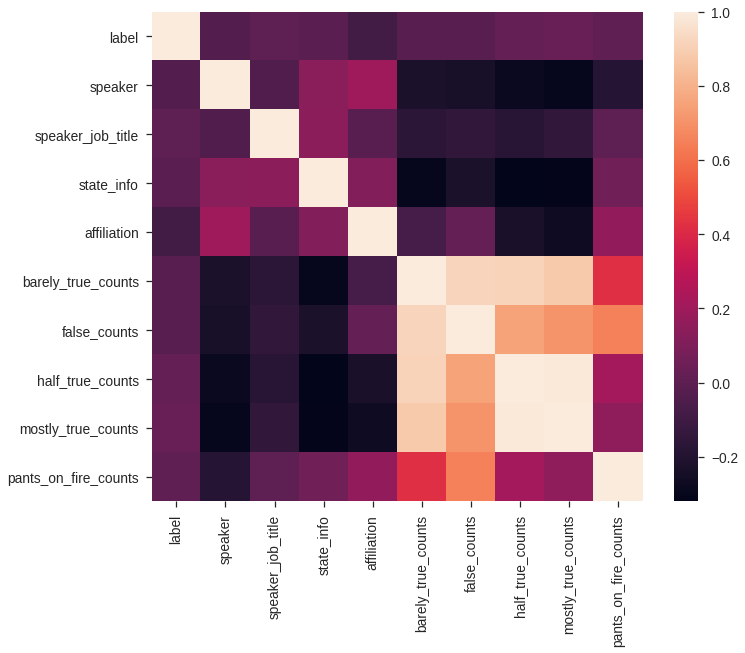

In [0]:
#Plotting Pearson correlation
corr=num_liar.corr()

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr)

As it can be seen above the features `speaker`, `state_info`, `false_counts` and `pants_on_fire_counts` seems to have an impact on `affiliation` factor.

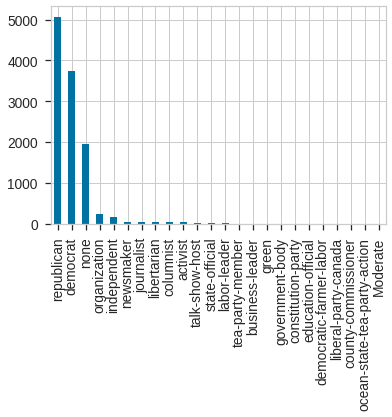

In [0]:
#looking at the distribution of party affiliation in the liar dataset
liar.affiliation.value_counts().plot(kind='bar')

As we can see in above plot most of the records belongs to only republican and democrat affiliation so in order to handle this class imbalance I am considering only **3 categories: republican, democrat and rest categories as other.**

In [0]:
def combine_party_affiliation_type(input_label):
    if input_label == 'democrat':
      return str('democrat')
    elif input_label == 'republican':
      return str('republican')
    else:
      return str('other')

liar['affiliation'] = liar.apply(lambda row: combine_party_affiliation_type(row['affiliation']), axis=1)

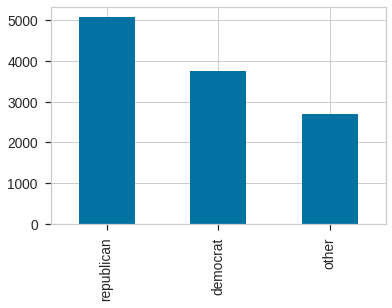

In [0]:
liar.affiliation.value_counts().plot(kind='bar')

The above plot shows the party affiliation labels after handling class imbalance.

Now, Let us look into the word cloud of processed text in liar dataset to see frequent used words

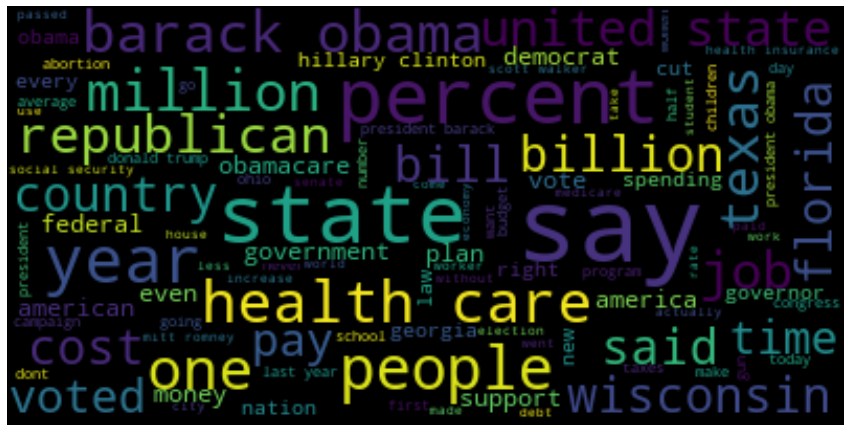

In [0]:
#Displaying wordcloud for Liar dataset
text= ' '.join(liar.CleanStatement)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## **Checking importance of features in liar dataset using Gini score to predict the fakeness label**

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

df= num_liar.copy()
#Dropping text columns
df = df.drop(['statement', 'subject', 'context', 'CleanStatement'], axis=1)

#Taking care of missing values in final liar dataset
df=df.fillna(0)

df.head()

,label,speaker,speaker_job_title,state_info,affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts
0,1,868,930,62,21,0.0,1.0,0.0,0.0,0.0
1,2,2653,928,69,6,0.0,0.0,1.0,1.0,0.0
2,3,197,686,19,6,70.0,71.0,160.0,163.0,9.0
3,1,290,1179,82,18,7.0,19.0,3.0,5.0,44.0
4,2,459,1179,13,6,15.0,9.0,20.0,19.0,2.0


In [0]:
#Splitting the data into train set and training set
X = df.drop('label', axis=1)
Y = df.label

#Normalizing the input data
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaled_X = scaler.fit_transform(X)

#Splitting dataset into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.4, random_state=1 )

clf = DecisionTreeClassifier(criterion='gini')
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(Y_test, y_pred)*100)

35.389963067564636


**The accuracy of the decision tree model with gini criterion to predict fakeness label is just 35%.**

In [0]:
#Finding importance of features on base liar dataset
clf.feature_importances_

array([0.116361, 0.066382, 0.05685 , 0.03133 , 0.169978, 0.138442, 0.079582, 0.20593 , 0.135145])

**It can be seen that in the base liar dataset the important features (with highest gini scores) comes out to be `speaker`, `barely_true_counts`, `false_counts`, `mostly_true_counts` and `pants_on_fire_counts` with values ranging from 0.11 to 0.21 to predict the fakeness label.**

## **Training 7 different models (LogisticRegression, DecisionTreeClassifier, GaussianNB, XGBClassifier, RandomForestClassifier, SVC and KNeighborsClassifier) to predict fakeness of statement between 1-6 using the base liar liar dataset.**

In [0]:
#Function to run different models and print confusion matrix, accuracy score, specificity and sensitivity of models
from sklearn.metrics import plot_confusion_matrix
def fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test):
  accuracy={}
  specificity={}
  sensitivity={}
  model_save=None
  i=0
  #models_dict holds name and its function , like {'LR':LogsticRegression()}
  for name,model in models_dict.items():
      #fitting model on the train data
      model.fit(X_train,y_train)
      #saving the model
      joblib.dump(model, name+'.pkl') 
      #predicting model on X_test 
      model_save=model
      y_pred=model.predict(X_test)
      print('*'*100)
      print('Model:',name)
      #printing Confusion matrix an dAccuracy of each model
      print("Confusion Matrix: ")
      print(confusion_matrix(y_test, y_pred))
      print("Accuracy : ",accuracy_score(y_test,y_pred)*100)

      #mainitaing a dictionary of results of accuracy of each model to use it to plot in one systyem
      accuracy[name]=accuracy_score(y_test,y_pred)*100
      cm=confusion_matrix(y_test, y_pred)
      sensitivity[name] = (cm[0,0]/(cm[0,0]+cm[0,1]))*100
      specificity[name] = (cm[1,1]/(cm[1,0]+cm[1,1]))*100
      print("Classificarion Report : ")
      print(classification_report(y_test, y_pred))
      
  
  #converting dictionaries to dataframes to have them handy
  accuracy=pd.DataFrame.from_dict(accuracy,orient='index').reset_index()
  sensitivity=pd.DataFrame.from_dict(sensitivity,orient='index').reset_index()
  specificity=pd.DataFrame.from_dict(specificity,orient='index').reset_index()
  # print(accuracy)
  accuracy.columns=['model_name','accuracy']
  sensitivity.columns=['model_name','sensitivity']
  specificity.columns=['model_name','specificity']
  
  #plotting accuracy,sensitivity,specificity of each model
  plt.figure(i+1,figsize=(16, 6))
  ax = sns.lineplot(data=accuracy, x='model_name', y='accuracy',legend='full')
  ax = sns.lineplot(data=sensitivity, x='model_name', y='sensitivity',legend='full')
  ax = sns.lineplot(data=specificity, x='model_name', y='specificity',legend='full')
  ax = sns.barplot(data=accuracy, x='model_name', y='accuracy')
  plt.title('Blue :Accuracy,Orange: Senstivity,Green : Specicificity ')
  return model_save

In [0]:
#Importing libraries
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#Defining dictionary of models to be trained
models_dict={}
# models_dict['LinearRegression']       = LinearRegression()
models_dict['LogisticRegression']     = LogisticRegression()
models_dict['Dtree']                  = DecisionTreeClassifier()
models_dict['NB']                     = GaussianNB()
models_dict['XGB']                    = XGBClassifier()
models_dict['RForest']                = RandomForestClassifier()
models_dict['SVM']                    = SVC(gamma='auto')
models_dict['KNN']                    = KNeighborsClassifier()

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[105 236 212 170   9   0]
 [ 67 421 191 200  19   0]
 [ 82 292 362 224   4   0]
 [ 44 266 222 333   6   0]
 [ 33 162  91  46  46   0]
 [ 44 229 228 256   3   0]]
Accuracy :  27.525526830328044
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.28      0.14      0.19       732
           1       0.26      0.47      0.34       898
           2       0.28      0.38      0.32       964
           3       0.27      0.38      0.32       871
           4       0.53      0.12      0.20       378
           5       0.00      0.00      0.00       760

    accuracy                           0.28      4603
   macro avg       0.27      0.25      0.23      4603
weighted avg       0.25      0.28      0.24      4603

********************************************************************************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

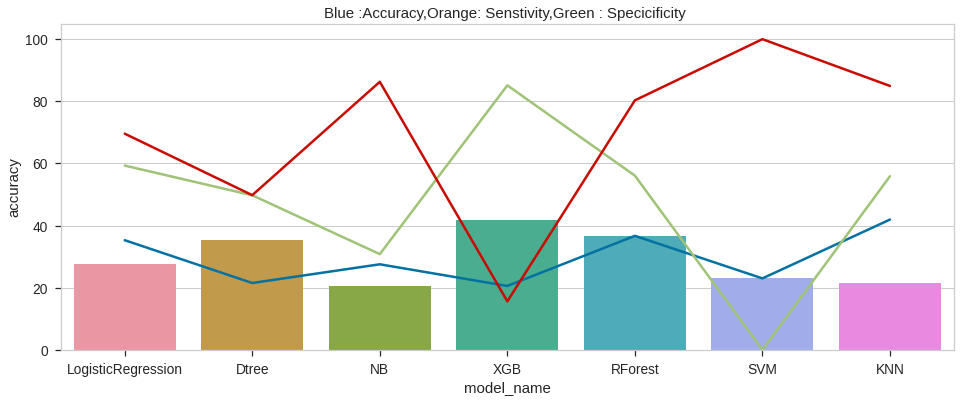

In [0]:
#Training different models and evaluating them
fitModelsAndPredict(models_dict,X_train,Y_train,X_test,Y_test)

**On initial liar liar dataset we are getting a max accuracy of `42%` by XG Boost model.**

## **Generating probability score vector for party affiliation which will give confidence scores towards each party affiliation and adding those as derived features to base liar dataset**

### **Creating doc2vec model**

Creating a word2vec model to generate custom embeddings word vectors for `statement` feature in our liar liar dataset so that it can be fed to train our models further.

In [0]:
data = liar.CleanStatement.tolist()

In [0]:
#Generating tagged documents for training word2vec model
tagged_data = []
exception_count = 0
for index, text in enumerate(data):
    try:
        tagged_data.append(TaggedDocument(words=word_tokenize(text.lower()), tags=[str(index)]))
    except:
        exception_count+=1

tagged_data[0]

TaggedDocument(words=['says', 'annies', 'list', 'political', 'group', 'supports', 'third', 'trimester', 'abortions', 'demand'], tags=['0'])

In [0]:
#Initializing hyperparameters for doc2vec model
vector_size = 10
d2v_model = Doc2Vec(size=vector_size, alpha=.025, min_alpha=.025, min_count=10, dm = 1)

#Building the vocabulary 
d2v_model.build_vocab(tagged_data)

#training model
d2v_model.train(tagged_data, total_examples=d2v_model.corpus_count, epochs=d2v_model.iter)

In [0]:
#Saving the model
d2v_model.save("doc2vec1.model")
print("Doc2Vec Model Saved")

Doc2Vec Model Saved


In [0]:
#Checking the embeddings generated by doc2vec model for a given text sample
text = "decline coal start started natural gas took started begin president george w bushs administration"
d2vmodel= Doc2Vec.load("doc2vec1.model")
test_ex= [d2vmodel.infer_vector(word_tokenize(text))]
print(test_ex)

[array([ 0.262886,  0.073201, -0.066193, -0.117752, -0.040263, -0.174177, -0.11552 , -0.086778, -0.188883,  0.159145],
      dtype=float32)]


### **Creating Training dataset for Neural Network**

Training a neural network on the doc2vec embeddings generated for `statement` feature and other categorical features from liar dataset (which have impact on our factor) such as `speaker`, `state_info`, `speaker_job_title` and `context` to generate a probability vector which gives the probability scores or you can say confidence towards each party affiliation.

Neural network is using softmax at the output layer to generate these probability scores and make the prediction for party affiliation as the one with the highest probability.

In [0]:
#Generating word embeddings for cleanstatement in liar dataset using previously trained Doc2Vec model
statement_wordvec = []
for statement in liar.CleanStatement.tolist():
    statement_wordvec.append(d2vmodel.infer_vector(word_tokenize(statement)))

In [0]:
#Defining training data for Neural Network
df = pd.DataFrame(statement_wordvec)
df['speaker'] = liar.speaker.tolist()
df['speaker_job_title']= liar.speaker_job_title.tolist()
df['state_info'] = liar.state_info.tolist()
df['context'] = liar.context.tolist()
df['party_affiliation'] = liar.affiliation.tolist()

df.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7','Embed_8', 'Embed_9', 'speaker', 'speaker_job_title', 'state_info', 'context', 'party_affiliation']

In [0]:
#Displaying training data for Neural network
df.tail(5)

,Embed_0,Embed_1,Embed_2,Embed_3,Embed_4,Embed_5,Embed_6,Embed_7,Embed_8,Embed_9,speaker,speaker_job_title,state_info,context,party_affiliation
11502,-0.187719,0.050896,0.073386,-0.180652,0.043944,0.071110,-0.087581,-0.097137,0.049780,0.060331,rick-scott,Governor,Florida,a news conference,republican
11503,-0.066542,0.000847,0.040187,0.037976,-0.021476,-0.003694,0.186181,-0.015236,-0.116667,0.051872,jay-nixon,Governor,Missouri,"on ABC's ""This Week""",democrat
11504,0.255691,0.161314,0.015860,-0.077951,0.057599,-0.112768,-0.142884,0.091813,0.008259,0.084993,mackubin-thomas-owens,"senior fellow, Foreign Policy Research Institute",Rhode Island,a commentary in The Providence Journal,other
11505,0.021770,-0.022556,-0.060089,-0.003400,0.147794,-0.145342,0.101269,-0.144598,-0.068843,0.051701,john-kasich,"Governor of Ohio as of Jan. 10, 2011",Ohio,a news conference,republican
11506,-0.261237,0.105890,-0.064632,-0.157488,0.066959,-0.268828,-0.058171,-0.304289,0.127046,0.141198,john-burzichelli,NaN,NaN,an interview with NJToday,democrat


### **Building the Neural Network model**

In [0]:
#Splitting dataset into train and test
train_df, test_df = train_test_split(df, test_size=0.15, random_state=1)
len(train_df), len(test_df)

(9780, 1727)

In [0]:
# Defining pre-processing we want for our fast.ai DataBunch
procs=[FillMissing, Categorify, Normalize]

# Preparing categorical and continous data columns for building Tabular DataBunch.
cat_vars = ['speaker', 'speaker_job_title', 'state_info']
cont_vars = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7', 'Embed_8', 'Embed_9']
# Defining the dependent (target) variable
dep_var = 'party_affiliation'

#Specifying the valid_idx variable as the cut out range.
valid_idx = range(1727)

train_df.columns = df.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7','Embed_8', 'Embed_9', 'speaker', 'speaker_job_title', 'state_info', 'context', 'party_affiliation']
test_df.columns = df.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7', 'Embed_8', 'Embed_9', 'speaker','speaker_job_title', 'state_info', 'context', 'party_affiliation']

#Preparing a test dataset
test = TabularList.from_df(test_df, path=Path(), cat_names=None, cont_names=cont_vars)

# Use fast.ai datablock api to put our training data into the DataBunch, getting ready for training
data = (TabularList.from_df(train_df, path=Path(), cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var)
                   .add_test(test, label=0)
                   .databunch())
data.show_batch(rows=10)

speaker,speaker_job_title,state_info,Embed_0,Embed_1,Embed_2,Embed_3,Embed_4,Embed_5,Embed_6,Embed_7,Embed_8,Embed_9,target
leticia-van-de-putte,Pharmacist,Texas,-0.1185,1.3354,0.2803,-0.0958,0.6399,-0.6575,0.5251,0.4376,0.7573,0.5522,democrat
harry-reid,Senate Democratic Leader,Nevada,1.4912,1.2564,-0.2922,1.7608,1.3874,-2.0466,0.5116,1.1004,0.9574,-0.8654,democrat
paul-begala,Affiliated professor of public policy at Georgetown University's Public Policy Institute,Texas,-0.3883,-0.3082,1.2835,-0.2800,-2.0031,-3.1953,-1.4474,-1.5329,2.3639,3.2716,democrat
david-prosser,Wisconsin Supreme Court justice,Wisconsin,0.0519,-0.4180,-0.6166,-1.2271,2.5543,-0.0758,-0.9333,0.5311,-0.6904,0.6039,other
gary-johnson,Presidential candidate,New Mexico,-0.3607,0.5542,-0.2055,0.2684,0.4243,0.3313,0.2347,0.0920,-0.0197,-1.3956,other
bernie-s,U.S. Senator,Vermont,2.7328,-2.2212,1.9991,0.3837,-0.7283,-1.0863,0.2834,1.5027,0.5635,2.7173,other
chain-email,#na#,#na#,-1.4674,1.1815,0.5676,0.4581,-1.2539,0.8684,-1.0314,-0.8578,1.2099,-0.6760,other
ed-rendell,Governor,Pennsylvania,-3.1102,3.1734,-0.9274,2.3153,-0.0571,-0.2550,0.6281,0.9158,3.2387,-2.1699,democrat
jack-seiler,Fort Lauderdale mayor,Florida,0.0708,-0.3579,0.7424,-0.8907,-0.1941,-0.3542,0.2035,-0.6328,-0.7915,0.6267,democrat
americans-united-change,#na#,#na#,-0.8524,1.4625,0.0420,-0.2840,2.1814,-2.5642,0.5975,-2.8532,-0.6189,1.5520,other


In [0]:
#defining the model
learn = tabular_learner(data, layers=[30,15,4],  metrics=accuracy,emb_drop=0.2)

In [0]:
#displaying the model parameters
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2489, 128)
    (1): Embedding(1034, 78)
    (2): Embedding(76, 18)
  )
  (emb_drop): Dropout(p=0.2, inplace=False)
  (bn_cont): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=234, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=30, out_features=15, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=15, out_features=4, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=4, out_features=3, bias=True)
  )
)

In [0]:
#fitting the learner and kept learning rate as le-3 because you can see in below learning rate curve the loss is minimum for this value
learn.fit_one_cycle(8,1e-2) 
#Saving the model
learn.save("NN_model")
learn.export()

epoch,train_loss,valid_loss,accuracy,time
0,0.856171,0.702611,0.709902,00:01
1,0.314710,0.325662,0.889983,00:01
2,0.097558,0.496802,0.906196,00:01
3,0.033561,0.550520,0.908512,00:01
4,0.008890,0.607359,0.912565,00:01
5,0.004456,0.597166,0.911986,00:01
6,0.001256,0.664507,0.910828,00:01
7,0.000542,0.665828,0.911407,00:01


**The NN model is achieving an accuracy of `91%` approx for predicting party affiliation.**

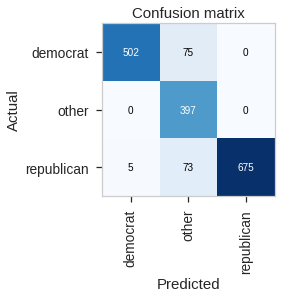

In [0]:
#Plotting the confusion matrix for the NN model
pred = ClassificationInterpretation.from_learner(learn)
pred.plot_confusion_matrix()

In [0]:
#Displaying the prediction for one of the test record
print(test_df.iloc[0],str(learn.predict(test_df.iloc[0])))

Embed_0             -0.142494                       
Embed_1             -0.0545875                      
Embed_2             -0.0266626                      
Embed_3              0.045382                       
Embed_4              0.152224                       
Embed_5             -0.0333439                      
Embed_6              0.025791                       
Embed_7             -0.187709                       
Embed_8             -0.0635795                      
Embed_9              0.079044                       
speaker              stephanie-cutter               
speaker_job_title    Co-host on CNN's "Crossfire"   
state_info           Massachusetts                  
context              an episode of CNN's "Crossfire"
party_affiliation    democrat                       
Name: 7617, dtype: object (Category tensor(0), tensor(0), tensor([9.9976e-01, 1.5968e-04, 8.4652e-05]))


**You can see the NN model has predicted the democrat correctly as 'democrat'** and have also provided us a vector denoting probaility (confidence) scores towards each party affiliation. Further we will be using these scores to identify fakeness of news.

Applying the NN trained model on liar liar dataset with statement word embeddings to get confidence scores towards each party.

###**Running the trained NN model on liar dataset to get the probability scores vector (confidence scores) towards each party affiliation**

In [0]:
#Defining the data to run model on
df_final = df.drop('party_affiliation', axis=1)
df_final.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7','Embed_8', 'Embed_9','speaker', 'speaker_job_title','state_info','context']
df_final.head()

,Embed_0,Embed_1,Embed_2,Embed_3,Embed_4,Embed_5,Embed_6,Embed_7,Embed_8,Embed_9,speaker,speaker_job_title,state_info,context
0,-0.005255,0.031505,0.015542,0.089229,0.019883,0.023065,-0.072902,0.098488,0.098475,0.039218,dwayne-bohac,State representative,Texas,a mailer
1,0.160434,0.024666,-0.094467,-0.089332,0.120406,-0.221200,-0.115396,-0.116941,-0.211452,0.073994,scott-surovell,State delegate,Virginia,a floor speech.
2,0.139248,0.163745,0.040829,-0.055558,0.104214,-0.136815,0.000582,-0.015808,-0.134379,0.068569,barack-obama,President,Illinois,Denver
3,0.062299,0.113330,-0.037844,0.070838,0.227733,-0.089745,0.000971,0.011232,0.030822,-0.046587,blog-posting,NaN,NaN,a news release
4,0.081309,0.051566,-0.001779,-0.008700,0.000772,-0.104532,-0.034303,-0.085464,-0.033398,0.065565,charlie-crist,NaN,Florida,an interview on CNN


In [0]:
#loading already trained NN model to get respective probability scores towards each individual party for every record in liar dataset
learn.load("NN_model")
probability_vector =[]
prediction =[]
for i in range(0,len(df_final)):
  pred = learn.predict(df_final.iloc[i])
  prediction.append(pred[0])
  probability_vector.append(pred[2])

In [0]:
##Converting the probailities obtained as a tensor to vectors so that it can be added to dataframe as columns
import numpy as np
prob_vector = []
for vector in probability_vector:
    v =[]
    for i in vector:
        a = float(i)
        v.append(a)
    prob_vector.append(v)

In [0]:
#Creating final training data to predict fakeness based on the probabilities towards each party affiliation
columns = ['Prob_republican','Prob_democrat', 'Prob_other', 'label']
final_df = pd.DataFrame(prob_vector)
final_df['label'] = liar.label.tolist()
final_df.columns = columns
final_df.head()

,Prob_republican,Prob_democrat,Prob_other,label
0,0.000130,0.000102,0.999768,false
1,0.999436,0.000414,0.000149,half-true
2,0.999905,0.000056,0.000039,mostly-true
3,0.000057,0.999827,0.000116,false
4,0.999803,0.000130,0.000067,half-true


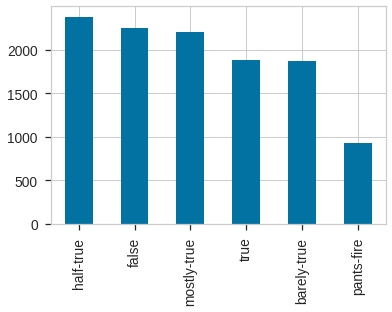

In [0]:
#looking at the distribution of fakeness class labels in the liar dataset
final_df.label.value_counts().plot(kind='bar')

## **Training 7 different models (LogisticRegression, DecisionTreeClassifier, GaussianNB, XGBClassifier, RandomForestClassifier,  SVC and KNeighborsClassifier) `to predict fakeness of statement between 1-6` using the party affiliation probability scores obtained using NN model**

In [0]:
#Taking care of missing values in final liar dataset
final_df=final_df.fillna(0)

In [0]:
#Converting categorical labels to numeric with 1 being true and 6 being pants-fire
def convertMulticlassToBinaryclass(v):
  if (v == 'true'):
    return 1 #'true'
  if (v == 'mostly-true'):
    return 2 #'true'
  if (v == 'half-true'):
    return 3 #'true'
  if (v == 'barely-true'):
    return 4 #'false'
  if (v == 'false'):
    return 5 #'false'
  if (v == 'pants-fire'):
    return 6 #'false'

final_df['label']=final_df['label'].map(lambda v: convertMulticlassToBinaryclass(v))

In [0]:
final_df.head()

,Prob_republican,Prob_democrat,Prob_other,label
0,0.000130,0.000102,0.999768,5
1,0.999436,0.000414,0.000149,3
2,0.999905,0.000056,0.000039,2
3,0.000057,0.999827,0.000116,5
4,0.999803,0.000130,0.000067,3


In [0]:
#Splitting the data into train set and training set
X = final_df.drop('label', axis=1)
Y = final_df.label

In [0]:
#Normalizing the input data
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [0]:
#Splitting dataset into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.4, random_state=1 )

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[  0 272 205   0 283   0]
 [  0 333 254   0 284   0]
 [  0 307 257   0 400   0]
 [  0 182 212   0 338   0]
 [  0 203 290   0 405   0]
 [  0  64 162   0 152   0]]
Accuracy :  21.61633717140995
Classificarion Report : 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       760
           2       0.24      0.38      0.30       871
           3       0.19      0.27      0.22       964
           4       0.00      0.00      0.00       732
           5       0.22      0.45      0.29       898
           6       0.00      0.00      0.00       378

    accuracy                           0.22      4603
   macro avg       0.11      0.18      0.14      4603
weighted avg       0.13      0.22      0.16      4603

*********************************************************************************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

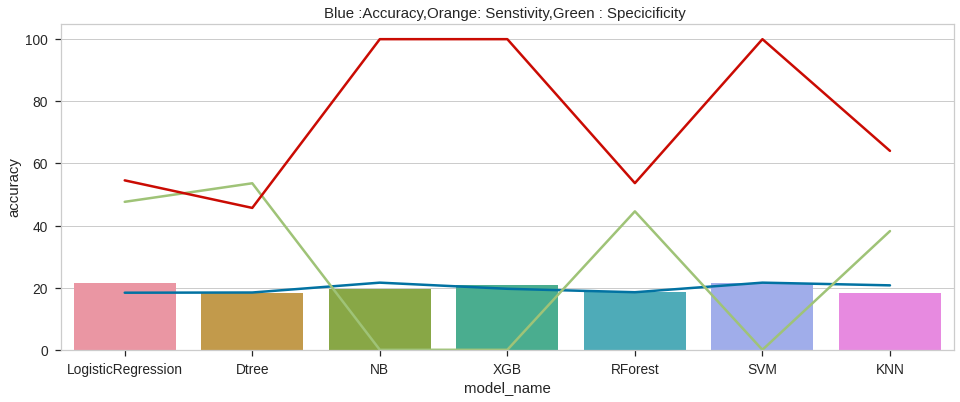

In [0]:
#Training different models and evaluating them
fitModelsAndPredict(models_dict,X_train,Y_train,X_test,Y_test)

As it can be seen from above graph that **SVM model is giving a highest accuracy of approx 22% in case of multiclass classification. And this is when we have chosen only features which are probability scores towards party affiliation generated by NN model to predict fakeness of a statement.**

## **Checking importance of added derived features using Gini score to predict the fakeness label**

In [0]:
clf = DecisionTreeClassifier(criterion='gini')
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
clf.feature_importances_

array([0.339769, 0.33099 , 0.32924 ])

**As you can see all the three derived features are having a strong importance in predicting fakeness of statement.**

## **Again running all the models with additional columns from base liar dataset along with derived party affiliation probability score features.**

Now lets try to add other columns from liar dataset which are `barely_true_counts`, `false_counts`, `half_true_counts`, `mostly_true_counts`, and `pants_on_fire_counts` alongwith the previously generated columns to see if this improves our models accuracy.

In [0]:
final_df_new = final_df.copy()
final_df_new['barely_true_counts'] = liar.barely_true_counts.tolist()
final_df_new['false_counts'] = liar.false_counts.tolist()
final_df_new['half_true_counts'] = liar.half_true_counts.tolist()
final_df_new['mostly_true_counts'] = liar.mostly_true_counts.tolist()
final_df_new['pants_on_fire_counts'] = liar.pants_on_fire_counts.tolist()

#Taking care of missing values in final liar dataset
final_df_new=final_df_new.fillna(0)

final_df_new.head()

,Prob_republican,Prob_democrat,Prob_other,label,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts
0,0.000130,0.000102,0.999768,5,0.0,1.0,0.0,0.0,0.0
1,0.999436,0.000414,0.000149,3,0.0,0.0,1.0,1.0,0.0
2,0.999905,0.000056,0.000039,2,70.0,71.0,160.0,163.0,9.0
3,0.000057,0.999827,0.000116,5,7.0,19.0,3.0,5.0,44.0
4,0.999803,0.000130,0.000067,3,15.0,9.0,20.0,19.0,2.0


In [0]:
#Splitting the data into train set and training set
X = final_df_new.drop('label', axis=1)
Y = final_df_new.label

In [0]:
#Normalizing the input data
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [0]:
#Splitting dataset into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.2, random_state=1 )

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[  0  99 148  24  94   3]
 [  0 176 130  30  92   3]
 [  0  88 231  42 122   4]
 [  0  68 141  45  99  10]
 [  0  81 181  30 155  19]
 [  0  23  79   9  50  26]]
Accuracy :  27.497827975673328
Classificarion Report : 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       368
           2       0.33      0.41      0.36       431
           3       0.25      0.47      0.33       487
           4       0.25      0.12      0.17       363
           5       0.25      0.33      0.29       466
           6       0.40      0.14      0.21       187

    accuracy                           0.27      2302
   macro avg       0.25      0.25      0.23      2302
weighted avg       0.24      0.27      0.24      2302

********************************************************************************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

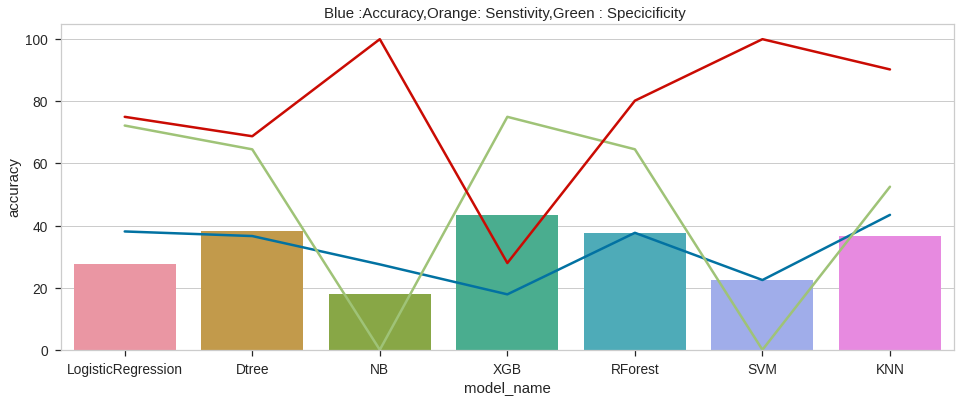

In [0]:
#Training different models and evaluating them
fitModelsAndPredict(models_dict,X_train,Y_train,X_test,Y_test)

**Above plot shows that adding columns `barely_true_counts`, `false_counts`, `half_true_counts`, `mostly_true_counts`, and `pants_on_fire_counts` alongwith the probability scores of party affiliation increased the model accuracy twice. Now, XG Boost is giving the best accuracy of approx 43.4%.**

## **Further adding LDA score to liar liar dataset**

As part of distillation performing LDA on liar liar dataset and adding LDA score to the dataset to see if this further improves the accuracy.

In [0]:
#Creating processed doc and dictionary
processed_docs = liar['CleanStatement'].map(lambda doc: doc.split(" "))

In [0]:
#Function to get tokens of document
def get_tokens(text):
    token = []
    for tk in gensim.utils.simple_preprocess(text):
        if len(tk) > 3:
            token.append(tk)
    return token

In [0]:
tokenized_docs = liar['CleanStatement'].map(get_tokens)

In [0]:
# Function to get dictionary
def get_dictionary(processed_docs):
    dict_gensim = gensim.corpora.Dictionary(processed_docs)
    dict_gensim.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dict_gensim

# Function to get Bag of Words
def get_bow_corpus(processed_docs, tokenized_docs):
    dict_gensim = get_dictionary(processed_docs)

    bow_corpus = [dict_gensim.doc2bow(doc) for doc in tokenized_docs]
    return bow_corpus

In [0]:
dictionary = get_dictionary(processed_docs)
bow_corpus = get_bow_corpus(processed_docs, tokenized_docs)

In [0]:
# Running LDA using Bag of Words on train dataset
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [0]:
# Checking the topics and words
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.028*"says" + 0.028*"obama" + 0.015*"barack" + 0.013*"years" + 0.013*"million" + 0.012*"taxes" + 0.012*"time" + 0.011*"president" + 0.010*"percent" + 0.010*"government"
Topic: 1 
Words: 0.044*"says" + 0.028*"president" + 0.019*"obama" + 0.018*"states" + 0.017*"jobs" + 0.012*"year" + 0.012*"barack" + 0.010*"since" + 0.009*"percent" + 0.009*"united"
Topic: 2 
Words: 0.040*"says" + 0.020*"texas" + 0.016*"year" + 0.015*"state" + 0.012*"income" + 0.010*"percent" + 0.009*"money" + 0.009*"billion" + 0.009*"republican" + 0.009*"people"
Topic: 3 
Words: 0.034*"percent" + 0.026*"states" + 0.019*"rate" + 0.018*"united" + 0.017*"people" + 0.015*"country" + 0.011*"state" + 0.011*"increase" + 0.010*"america" + 0.009*"budget"
Topic: 4 
Words: 0.042*"says" + 0.022*"percent" + 0.016*"insurance" + 0.011*"years" + 0.011*"health" + 0.009*"security" + 0.009*"state" + 0.009*"social" + 0.009*"spending" + 0.008*"would"
Topic: 5 
Words: 0.073*"says" + 0.033*"state" + 0.016*"scott" + 0.013*"ho

In [0]:
# Getting score
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.5418851375579834	 
Topic: 0.073*"says" + 0.033*"state" + 0.016*"scott" + 0.013*"house" + 0.012*"romney" + 0.012*"mitt" + 0.010*"campaign" + 0.009*"president" + 0.008*"walker" + 0.008*"budget"

Score: 0.3781016170978546	 
Topic: 0.022*"percent" + 0.021*"says" + 0.019*"obama" + 0.018*"would" + 0.015*"health" + 0.014*"care" + 0.013*"president" + 0.013*"said" + 0.010*"clinton" + 0.010*"plan"

Score: 0.010002722032368183	 
Topic: 0.044*"says" + 0.028*"president" + 0.019*"obama" + 0.018*"states" + 0.017*"jobs" + 0.012*"year" + 0.012*"barack" + 0.010*"since" + 0.009*"percent" + 0.009*"united"

Score: 0.010002189315855503	 
Topic: 0.039*"health" + 0.038*"care" + 0.022*"says" + 0.020*"bill" + 0.019*"percent" + 0.018*"jobs" + 0.017*"would" + 0.014*"federal" + 0.012*"state" + 0.011*"government"

Score: 0.010001912713050842	 
Topic: 0.028*"says" + 0.028*"obama" + 0.015*"barack" + 0.013*"years" + 0.013*"million" + 0.012*"taxes" + 0.012*"time" + 0.011*"president" + 0.010*"percent" + 0.010*

In [0]:
#Adding LDA score to our final dataset used for prediction alongwith our columns
final_df_new['LDA_Score'] = score
final_df_new.head()

,Prob_republican,Prob_democrat,Prob_other,label,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,LDA_Score
0,0.000145,0.000063,0.999792,5,0.0,1.0,0.0,0.0,0.0,0.010001
1,0.999853,0.000100,0.000047,3,0.0,0.0,1.0,1.0,0.0,0.010001
2,0.999795,0.000132,0.000073,2,70.0,71.0,160.0,163.0,9.0,0.010001
3,0.000027,0.999964,0.000009,5,7.0,19.0,3.0,5.0,44.0,0.010001
4,0.999752,0.000144,0.000104,3,15.0,9.0,20.0,19.0,2.0,0.010001


## **Again running all the models on above dataset for predicting fakeness after adding LDA score along with additional columns from base liar dataset plus derived party affiliation probability score features.**

In [0]:
#Splitting the data into train set and training set
X = final_df_new.drop('label', axis=1)
Y = final_df_new.label

In [0]:
#Normalizing the input data
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [0]:
#Splitting dataset into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.4, random_state=1 )

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[  0 182 326  46 202   4]
 [  0 282 325  57 197  10]
 [  0 133 489  81 253   8]
 [  0 129 288  81 221  13]
 [  0 152 344  60 313  29]
 [  0  40 145  23 111  59]]
Accuracy :  26.591353465131434
Classificarion Report : 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       760
           2       0.31      0.32      0.32       871
           3       0.26      0.51      0.34       964
           4       0.23      0.11      0.15       732
           5       0.24      0.35      0.29       898
           6       0.48      0.16      0.24       378

    accuracy                           0.27      4603
   macro avg       0.25      0.24      0.22      4603
weighted avg       0.24      0.27      0.23      4603

********************************************************************************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

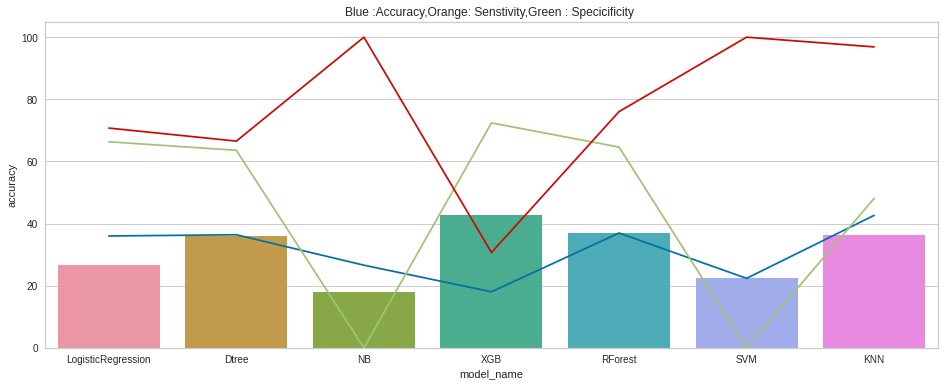

In [0]:
#Training different models and evaluating them
fitModelsAndPredict(models_dict,X_train,Y_train,X_test,Y_test)

**We can see adding LDA score did not help us to improve accuracies of our model. We are still getting highest accuracy of `~43%` with XG Boost model.**

## **Checking importance of added derived feature LDA using Gini score to predict the fakeness label**

In [0]:
clf = DecisionTreeClassifier(criterion='gini')
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
clf.feature_importances_

array([0.244518, 0.205626, 0.237085, 0.072831, 0.06272 , 0.039133, 0.082204, 0.055884, 0.      ])

**LDA score has no impact on the prediction of fakeness as it has zero gini score.**

# **Adding second dataset for data enrichment**

Now I am going to amalgamate liar liar dataset with NY times articles dataset taken from Kaggle to see if data enrichment can help improve accuracies of our models in order to predict fakeness.

[NY time articles dataset](https://www.kaggle.com/nayansolanki2411/headlines-of-2018)

## **Loading dataset NY times articles**

It which contains articles from 2017 and 2018

In [0]:
#Defining link to the dataset
link = 'https://drive.google.com/open?id=1tTqAKrc6GudZFRZbhGA9smRrR63IlfoG'
fluff, id = link.split('=')

#downloading the file
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('NYT_headlines.txt')

NY_data = pd.read_csv('NYT_headlines.txt', error_bad_lines=False, delimiter='\t')
# NY_text = NY_data[['headline_text']]
# NY_text['index'] = NY_text.index
# documents = NY_text
# nyt_headlines_dataset = documents.headline_text.tolist()


In [0]:
NY_data.head()

,headline_text
0,finding an expansive view of a forgotten people in niger
1,"and now, the dreaded trump curse"
2,venezuela’s descent into dictatorship
3,stain permeates basketball blue blood
4,taking things for granted


 ## **Cleaning NY times article dataset**

Cleaning the dataset includes: 
Stopwords removal, stemming, lemmatization, converting to lowercase, removing punctuations, special characters and digits, and word tokenization

In [0]:
#Defining stop words for removal
stop_words = set(stopwords.words('english'))

#Removing punctations ,special characters and digits.
#Converting all the text to lower case and then work_tokenizing them and storing it in a column called CleanStatement

NY_data.dropna()
NY_data['CleanHeadline'] = NY_data['headline_text'].map(lambda x: re.sub(r"\W", " ",str(x)))
NY_data['CleanHeadline'] = NY_data['CleanHeadline'].map(lambda x: re.sub(r'[,\.!?]', " ",str(x)))
NY_data['CleanHeadline'] = NY_data['CleanHeadline'].map(lambda x: re.sub(r" \d+", " ",str(x)))
NY_data['CleanHeadline'] = NY_data['CleanHeadline'].map(lambda x: word_tokenize(x.lower()))

NY_data['CleanHeadline'] = NY_data['CleanHeadline'].map(lambda x: ' '.join(x))
NY_data['CleanHeadline'] = NY_data['CleanHeadline'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

NY_data.head()

,headline_text,CleanHeadline
0,finding an expansive view of a forgotten people in niger,finding expansive view forgotten people niger
1,"and now, the dreaded trump curse",dreaded trump curse
2,venezuela’s descent into dictatorship,venezuela descent dictatorship
3,stain permeates basketball blue blood,stain permeates basketball blue blood
4,taking things for granted,taking things granted


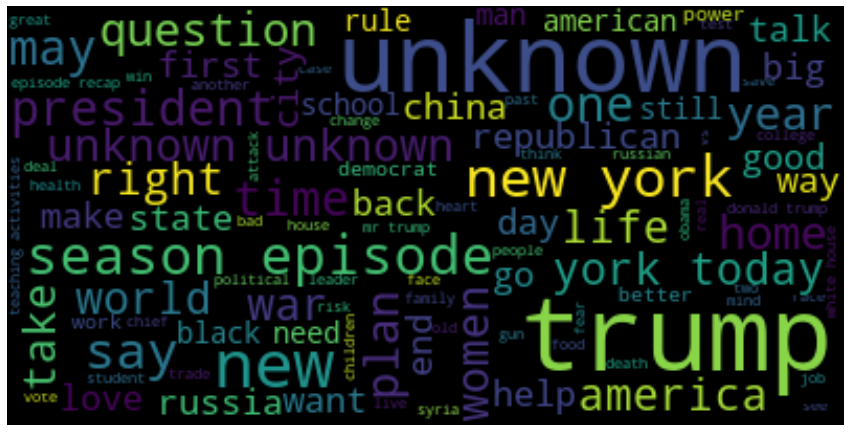

In [0]:
#Displaying wordcloud for Liar dataset
text= ' '.join(NY_data.CleanHeadline)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## **Performing LDA on NY times article dataset**

As part of distillation performing LDA on NY times dataset and generating 10 topics with the LDA model, to get an insight of topics it contains.

In [0]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words=stop_words)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(NY_data['CleanHeadline'])

In [0]:
l = []
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        l.append(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1,random_state=21)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
season episode recap death win americans dead walking see billions

Topic #1:
unknown get trump case new vote home democrats old room

Topic #2:
left behind power talk eat law obama one family truth

Topic #3:
north going korea picture south men get top women think

Topic #4:
trump mr variety war donald really still court trade little

Topic #5:
new york today may trump rules day russia help making

Topic #6:
trump life house race attack money white questions russia give

Topic #7:
control gun children bannon know cuomo college black learn art

Topic #8:
trump health plan like next care go better year taking

Topic #9:
america trump teaching two good facebook make party activities great


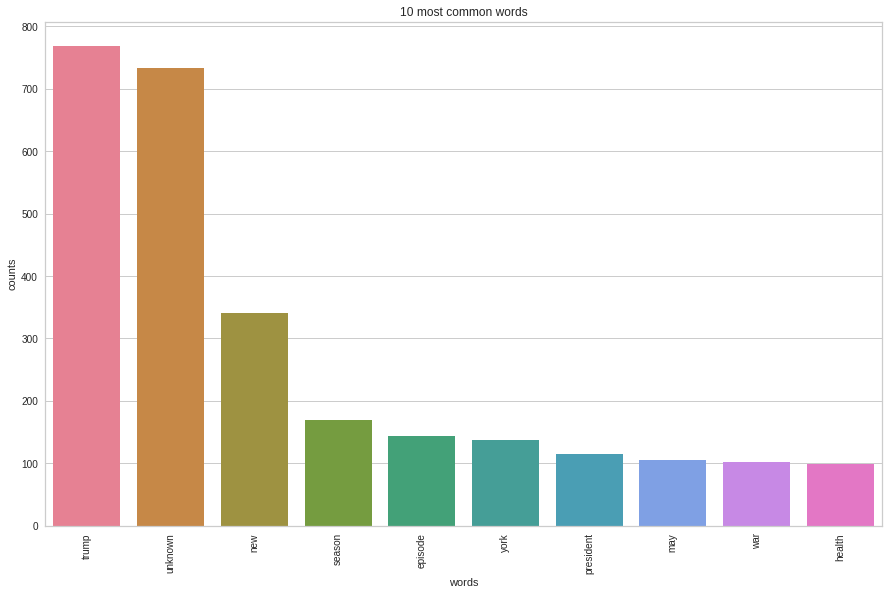

In [0]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

**As we can see above, NY times article dataset also contains similar topics to liar dataset which mainly comprises of trump, hillary, clinton, elections , US that is around political stuff. So, I am combining text of these two datasets into a single corpus to create doc2vec embeddings using this enriched data and see if this further improves accuracy**

## **Combining text of liar liar and NY times article datasets to create a doc2vec model**

In [0]:
data = []
data = liar.CleanStatement.tolist() + NY_data.CleanHeadline.tolist()

In [0]:
#Generating tagged documents for training doc2vec model
tagged_data = []
exception_count = 0
for index, text in enumerate(data):
    try:
        tagged_data.append(TaggedDocument(words=word_tokenize(text.lower()), tags=[str(index)]))
    except:
        exception_count+=1

tagged_data[0]

TaggedDocument(words=['says', 'annies', 'list', 'political', 'group', 'supports', 'third', 'trimester', 'abortions', 'demand'], tags=['0'])

## **Train Doc2Vec Model on enriched data**

In [0]:
#Initializing hyperparameters for doc2vec model
vector_size = 10
d2v_model2 = Doc2Vec(size=vector_size, alpha=.025, min_alpha=.025, min_count=10, dm = 1)

#Building the vocabulary 
d2v_model2.build_vocab(tagged_data)

#training model
d2v_model2.train(tagged_data, total_examples=d2v_model2.corpus_count, epochs=d2v_model2.iter)

In [0]:
#Saving the model
d2v_model2.save("doc2vec2.model")
print("Doc2Vec Model 2 Saved")

Doc2Vec Model 2 Saved


## **Creating Training dataset for Neural Network using doc2vec model built on enriched data**

Using NN model we will be generating a new probability vector which will give the confidence scores towards each party affiliation and after that we will use those features for our final prediction of fakeness.

In [0]:
#Generating word embeddings for cleanstatement in liar dataset using previously trained Doc2Vec model
statement_wordvec = []
for statement in liar.CleanStatement.tolist():
    statement_wordvec.append(d2v_model2.infer_vector(word_tokenize(statement)))

In [0]:
#Defining training data for Neural Network
df = pd.DataFrame(statement_wordvec)
df['speaker'] = liar.speaker.tolist()
df['speaker_job_title']= liar.speaker_job_title.tolist()
df['state_info'] = liar.state_info.tolist()
df['context'] = liar.context.tolist()
df['party_affiliation'] = liar.affiliation.tolist()

df.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7','Embed_8', 'Embed_9', 'speaker', 'speaker_job_title', 'state_info', 'context', 'party_affiliation']

In [0]:
#Displaying training data for Neural network
df.tail(5)

,Embed_0,Embed_1,Embed_2,Embed_3,Embed_4,Embed_5,Embed_6,Embed_7,Embed_8,Embed_9,speaker,speaker_job_title,state_info,context,party_affiliation
11502,-0.105904,-0.141267,0.029696,-0.128738,-0.190775,0.364426,-0.131999,0.086538,0.130790,0.275242,rick-scott,Governor,Florida,a news conference,republican
11503,-0.030590,-0.096560,0.050351,0.009072,-0.165583,0.127998,0.178722,0.081554,-0.093969,0.083663,jay-nixon,Governor,Missouri,"on ABC's ""This Week""",democrat
11504,0.163474,0.159642,-0.006698,-0.066954,-0.096232,-0.098102,-0.155007,0.116554,-0.029599,-0.050784,mackubin-thomas-owens,"senior fellow, Foreign Policy Research Institute",Rhode Island,a commentary in The Providence Journal,other
11505,0.044865,-0.065637,-0.067840,0.057250,-0.065544,-0.079014,0.002586,-0.026080,-0.055934,0.001679,john-kasich,"Governor of Ohio as of Jan. 10, 2011",Ohio,a news conference,republican
11506,-0.317568,-0.141157,-0.000813,-0.174352,-0.229408,0.150511,-0.187843,-0.091585,0.263889,0.206627,john-burzichelli,NaN,NaN,an interview with NJToday,democrat


## **Building the Neural Network model**

While building this model, the training word embedding features are generated using new enriched Doc2Vec model 2. 

In [0]:
#Splitting dataset into train and test
train_df, test_df = train_test_split(df, test_size=0.15, random_state=1)
len(train_df), len(test_df)

(9780, 1727)

In [0]:
# Defining pre-processing we want for our fast.ai DataBunch
procs=[FillMissing, Categorify, Normalize]

# Preparing categorical and continous data columns for building Tabular DataBunch.
cat_vars = ['speaker', 'speaker_job_title', 'state_info']
cont_vars = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7', 'Embed_8', 'Embed_9']
# Defining the dependent (target) variable
dep_var = 'party_affiliation'

#Specifying the valid_idx variable as the cut out range.
valid_idx = range(1727)

train_df.columns = df.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7','Embed_8', 'Embed_9', 'speaker', 'speaker_job_title', 'state_info', 'context', 'party_affiliation']
test_df.columns = df.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7', 'Embed_8', 'Embed_9', 'speaker','speaker_job_title', 'state_info', 'context', 'party_affiliation']

#Preparing a test dataset
test = TabularList.from_df(test_df, path=Path(), cat_names=None, cont_names=cont_vars)

# Use fast.ai datablock api to put our training data into the DataBunch, getting ready for training
data = (TabularList.from_df(train_df, path=Path(), cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var)
                   .add_test(test, label=0)
                   .databunch())
data.show_batch(rows=10)

speaker,speaker_job_title,state_info,Embed_0,Embed_1,Embed_2,Embed_3,Embed_4,Embed_5,Embed_6,Embed_7,Embed_8,Embed_9,target
nathan-deal,#na#,#na#,0.1650,0.4129,-0.1301,-0.5436,0.6542,-0.7939,-0.8274,0.2508,-0.7096,-0.4489,republican
mike-pence,Governor,Indiana,2.8271,-0.0744,0.4856,-0.1754,-1.5725,0.0125,-1.4961,1.7618,0.6973,0.9856,republican
steny-hoyer,House Majority Leader,Maryland,1.1873,2.0540,-0.3923,-2.7974,-0.6257,-0.8597,1.0146,-1.1573,-0.4084,1.8802,democrat
vernon-jones,#na#,#na#,2.1683,-0.2134,-0.4218,0.8614,0.2935,-0.3748,0.2958,-0.0213,-0.4398,1.7365,democrat
donald-trump,President-Elect,New York,0.7029,0.0847,0.6919,2.7884,0.6716,-2.3744,-0.3118,0.8543,-0.7789,1.4158,republican
democratic-congressional-leadership,#na#,#na#,0.6141,0.9437,0.0386,-0.0795,-0.0141,0.0255,0.0695,0.6657,0.4238,0.0154,democrat
republican-national-committee-republican,#na#,#na#,0.6583,0.2470,0.3260,0.5273,0.3632,0.5003,-0.4519,1.4573,1.5962,1.2865,republican
stephen-hayes,Senior writer for the Weekly Standard,#na#,0.3325,0.8167,0.5147,0.5647,0.4732,-1.1005,-0.5830,0.3280,-0.2795,0.0534,other
john-mccain,U.S. senator,Arizona,0.0469,0.6793,0.1154,-0.3199,0.6433,-1.0459,-0.3184,-0.2358,-0.5368,-0.8552,republican
paul-ryan,U.S. Representative,Wisconsin,-2.1390,-1.7053,-1.4635,-0.3218,-1.7743,2.2577,-3.1254,-0.1583,0.0291,1.0396,republican


In [0]:
#defining the model
learn2 = tabular_learner(data, layers=[30,15,4],  metrics=accuracy,emb_drop=0.2)

In [0]:
#fitting the learner and kept learning rate as le-3 because you can see in below learning rate curve the loss is minimum for this value
learn2.fit_one_cycle(8,1e-2) 
#Saving the model
learn2.save("NN_model2")
learn2.export()

epoch,train_loss,valid_loss,accuracy,time
0,0.806372,0.507316,0.832658,00:01
1,0.290122,0.659312,0.894036,00:01
2,0.090779,0.536683,0.910249,00:01
3,0.032616,0.681637,0.906775,00:01
4,0.011154,0.660032,0.912565,00:01
5,0.007108,0.715505,0.913144,00:01
6,0.001721,0.714941,0.914302,00:01
7,0.000669,0.720995,0.914302,00:01


**We could see this new NN model which is trained on enriched data is achieving an accuracy of `91%` approx for predicting party affiliation which is same as what we got in case of base dataset.**

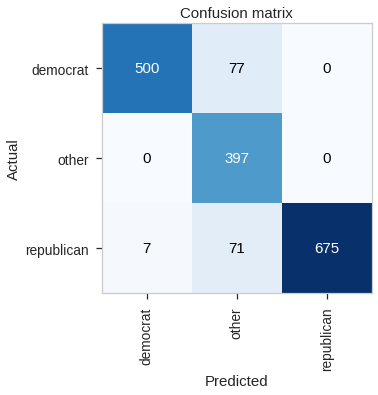

In [0]:
#Plotting the confusion matrix for the NN model
pred = ClassificationInterpretation.from_learner(learn)
pred.plot_confusion_matrix()

##**Running the newly trained NN model on liar dataset to get the probability scores vector (confidence scores) towards each party affiliation**

In [0]:
#Defining the data to run model on
df_final = df.drop('party_affiliation', axis=1)
df_final.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7','Embed_8', 'Embed_9','speaker', 'speaker_job_title','state_info','context']
df_final.dropna(subset = ['speaker', 'speaker_job_title','state_info','context'], inplace=True)
df_final.head()

,Embed_0,Embed_1,Embed_2,Embed_3,Embed_4,Embed_5,Embed_6,Embed_7,Embed_8,Embed_9,speaker,speaker_job_title,state_info,context
0,-0.042801,-0.048417,0.021768,0.100824,-0.067705,0.092856,-0.051838,0.112310,0.076867,0.023914,dwayne-bohac,State representative,Texas,a mailer
1,0.108954,-0.041096,-0.077975,-0.153126,-0.225820,-0.125170,-0.133493,0.005730,-0.130799,0.081832,scott-surovell,State delegate,Virginia,a floor speech.
2,0.073282,0.162912,0.007880,-0.147401,-0.107323,-0.140929,-0.046943,-0.023180,-0.008668,0.069684,barack-obama,President,Illinois,Denver
5,0.118269,-0.149888,-0.080281,-0.001218,-0.095222,0.010009,0.125128,-0.170262,-0.095350,0.093498,robin-vos,Wisconsin Assembly speaker,Wisconsin,a an online opinion-piece
7,0.099256,-0.119044,-0.042961,0.106489,-0.281680,0.203795,-0.030792,0.194008,0.090020,-0.047905,barack-obama,President,Illinois,"a Democratic debate in Philadelphia, Pa."


In [0]:
#loading newly trained NN model to get respective probability scores towards each individual party for every record in liar dataset
learn2.load("NN_model2")
probability_vector =[]
prediction =[]
for i in range(0,len(df_final)):
  pred = learn2.predict(df_final.iloc[i])
  prediction.append(pred[0])
  probability_vector.append(pred[2])

In [0]:
##Converting the probailities obtained as a tensor to vectors so that it can be added to dataframe as columns
import numpy as np
prob_vector = []
for vector in probability_vector:
    v =[]
    for i in vector:
        a = float(i)
        v.append(a)
    prob_vector.append(v)

In [0]:
#Creating final training data to predict fakeness based on the probabilities towards each party affiliation
liar.dropna(subset= ['speaker', 'speaker_job_title','state_info','context'], inplace=True)
columns = ['Prob_republican','Prob_democrat', 'Prob_other', 'label']
final_df = pd.DataFrame(prob_vector)
final_df['label'] = liar.label.tolist()
final_df.columns = columns
final_df.head()

,Prob_republican,Prob_democrat,Prob_other,label
0,0.000129,0.000048,0.999823,false
1,0.999658,0.000123,0.000218,half-true
2,0.999628,0.000177,0.000195,mostly-true
3,0.000098,0.000083,0.999819,true
4,0.999650,0.000139,0.000210,half-true


## **Training 7 different models (LogisticRegression, DecisionTreeClassifier, GaussianNB, XGBClassifier, RandomForestClassifier,  SVC and KNeighborsClassifier) `to predict fakeness of statement between 1-6` using the party affiliation probability scores obtained using `new NN model`**

In [0]:
#Taking care of missing values in final liar dataset
final_df=final_df.fillna(0)

In [0]:
#Converting categorical labels to numeric with 1 being true and 6 being pants-fire
def convertMulticlassToBinaryclass(v):
  if (v == 'true'):
    return 1 #'true'
  if (v == 'mostly-true'):
    return 2 #'true'
  if (v == 'half-true'):
    return 3 #'true'
  if (v == 'barely-true'):
    return 4 #'false'
  if (v == 'false'):
    return 5 #'false'
  if (v == 'pants-fire'):
    return 6 #'false'

final_df['label']=final_df['label'].map(lambda v: convertMulticlassToBinaryclass(v))

In [0]:
final_df.head()

,Prob_republican,Prob_democrat,Prob_other,label
0,0.000129,0.000048,0.999823,5
1,0.999658,0.000123,0.000218,3
2,0.999628,0.000177,0.000195,2
3,0.000098,0.000083,0.999819,1
4,0.999650,0.000139,0.000210,3


In [0]:
#Splitting the data into train set and training set
X = final_df.drop('label', axis=1)
Y = final_df.label

In [0]:
#Normalizing the input data
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [0]:
#Splitting dataset into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.4, random_state=1 )

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[  0 300   0   0 214   0]
 [  0 371   0   0 257   0]
 [  0 354   0   0 292   0]
 [  0 212   0   0 250   0]
 [  0 240   0   0 354   0]
 [  0  69   0   0 118   0]]
Accuracy :  23.919498515341473
Classificarion Report : 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       514
           2       0.24      0.59      0.34       628
           3       0.00      0.00      0.00       646
           4       0.00      0.00      0.00       462
           5       0.24      0.60      0.34       594
           6       0.00      0.00      0.00       187

    accuracy                           0.24      3031
   macro avg       0.08      0.20      0.11      3031
weighted avg       0.10      0.24      0.14      3031

********************************************************************************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

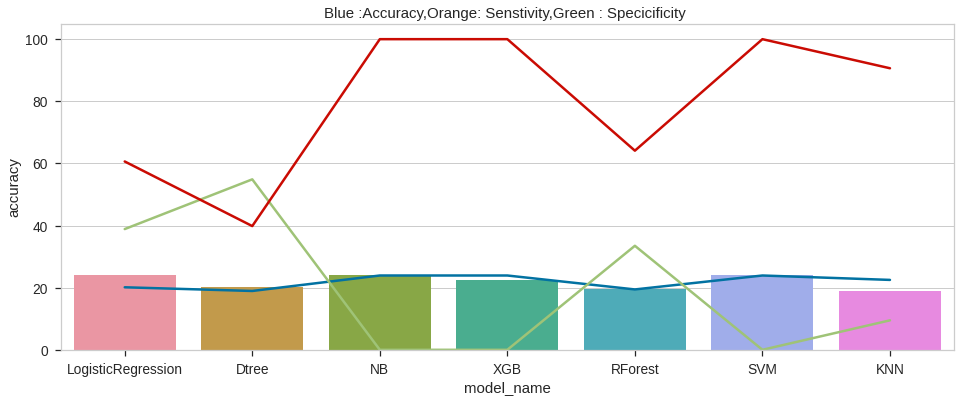

In [0]:
#Training different models and evaluating them
fitModelsAndPredict(models_dict,X_train,Y_train,X_test,Y_test)

**We could see amalgamating the datasets resulted in improved accuracy by 2% i.e., `from 22% to 24%` using the same number of columns which is given by `Naive Bayes and SVM models`**

Now lets try to add other columns from liar dataset which are barely_true_counts, false_counts, half_true_counts, mostly_true_counts, and pants_on_fire_counts alongwith the newly trained NN model generated columns to see if this improves our models accuracy.

In [0]:
final_df_new = final_df.copy()
final_df_new['barely_true_counts'] = liar.barely_true_counts.tolist()
final_df_new['false_counts'] = liar.false_counts.tolist()
final_df_new['half_true_counts'] = liar.half_true_counts.tolist()
final_df_new['mostly_true_counts'] = liar.mostly_true_counts.tolist()
final_df_new['pants_on_fire_counts'] = liar.pants_on_fire_counts.tolist()

#Taking care of missing values in final liar dataset
final_df_new=final_df_new.fillna(0)
final_df_new.dropna(subset=['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts'], inplace = True)
final_df_new.head()

,Prob_republican,Prob_democrat,Prob_other,label,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts
0,0.000129,0.000048,0.999823,5,0.0,1.0,0.0,0.0,0.0
1,0.999658,0.000123,0.000218,3,0.0,0.0,1.0,1.0,0.0
2,0.999628,0.000177,0.000195,2,70.0,71.0,160.0,163.0,9.0
3,0.000098,0.000083,0.999819,1,0.0,3.0,2.0,5.0,1.0
4,0.999650,0.000139,0.000210,3,70.0,71.0,160.0,163.0,9.0


In [0]:
#Splitting the data into train set and training set
X = final_df_new.drop('label', axis=1)
Y = final_df_new.label

In [0]:
#Normalizing the input data
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [0]:
#Splitting dataset into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.2, random_state=1 )

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[  0 139  46  10  66   0]
 [  0 174  59  19  71   0]
 [  0 150  73  16  82   0]
 [  0  98  49  10  78   0]
 [  0 107  36   7 134   0]
 [  0  29  20   3  40   0]]
Accuracy :  25.79155672823219
Classificarion Report : 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       261
           2       0.25      0.54      0.34       323
           3       0.26      0.23      0.24       321
           4       0.15      0.04      0.07       235
           5       0.28      0.47      0.35       284
           6       0.00      0.00      0.00        92

    accuracy                           0.26      1516
   macro avg       0.16      0.21      0.17      1516
weighted avg       0.18      0.26      0.20      1516

*********************************************************************************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

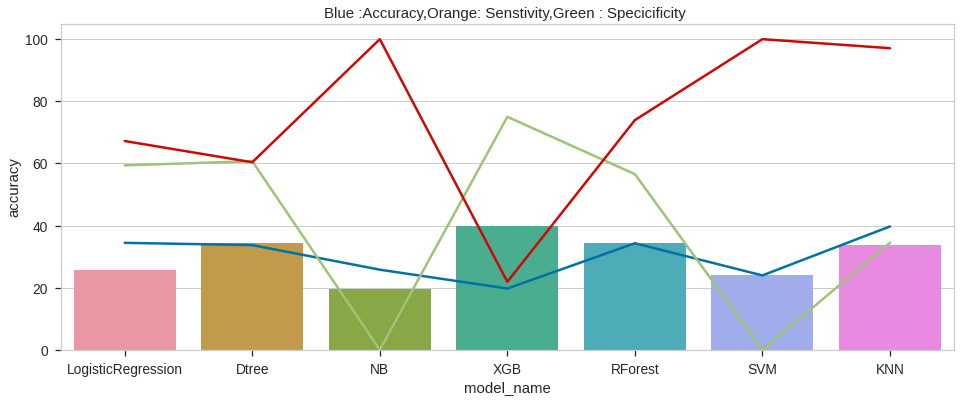

In [0]:
#Training different models and evaluating them
fitModelsAndPredict(models_dict,X_train,Y_train,X_test,Y_test)

**Adding features `barely_true_counts`, `false_counts`, `half_true_counts`, `mostly_true_counts`, and `pants_on_fire_counts` alongwith the probability scores of party affiliation `helped improve the accuracy than before from 24% to 40.3%` but strangely this is lesser than what we got before enrichment with the same number of columns which was 43%.**

## **Adding LDA score to final dataset used for prediction to see if this improves accuracy after data enrichment**

In [0]:
#Adding LDA score to our final dataset used for prediction alongwith our columns
final_df_new['LDA_Score'] = score
final_df_new.head()

,Prob_republican,Prob_democrat,Prob_other,label,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,LDA_Score
0,0.000129,0.000048,0.999823,5,0.0,1.0,0.0,0.0,0.0,0.010001
1,0.999658,0.000123,0.000218,3,0.0,0.0,1.0,1.0,0.0,0.010001
2,0.999628,0.000177,0.000195,2,70.0,71.0,160.0,163.0,9.0,0.010001
3,0.000098,0.000083,0.999819,1,0.0,3.0,2.0,5.0,1.0,0.010001
4,0.999650,0.000139,0.000210,3,70.0,71.0,160.0,163.0,9.0,0.010001


**Again running all the models on above dataset for predicting fakeness**

In [0]:
#Splitting the data into train set and training set
X = final_df_new.drop('label', axis=1)
Y = final_df_new.label

In [0]:
#Normalizing the input data
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [0]:
#Splitting dataset into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.2, random_state=1 )

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[  0 139  46  10  66   0]
 [  0 174  59  19  71   0]
 [  0 150  73  16  82   0]
 [  0  98  49  10  78   0]
 [  0 107  36   7 134   0]
 [  0  29  20   3  40   0]]
Accuracy :  25.79155672823219
Classificarion Report : 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       261
           2       0.25      0.54      0.34       323
           3       0.26      0.23      0.24       321
           4       0.15      0.04      0.07       235
           5       0.28      0.47      0.35       284
           6       0.00      0.00      0.00        92

    accuracy                           0.26      1516
   macro avg       0.16      0.21      0.17      1516
weighted avg       0.18      0.26      0.20      1516

*********************************************************************************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

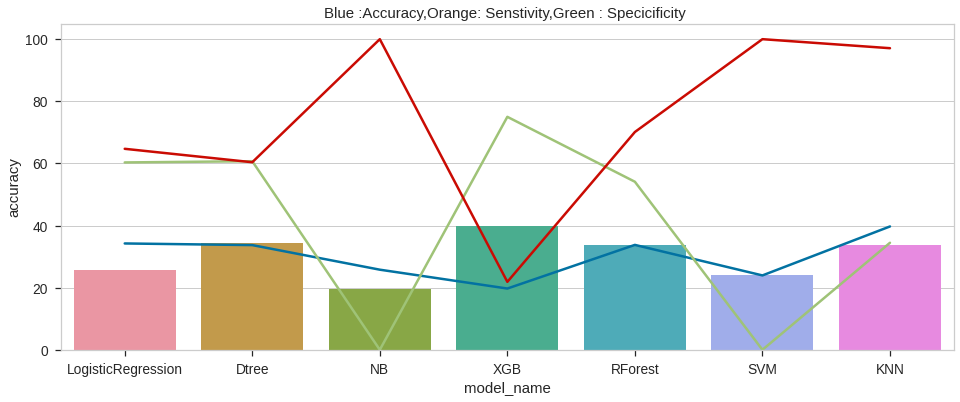

In [0]:
#Training different models and evaluating them
fitModelsAndPredict(models_dict,X_train,Y_train,X_test,Y_test)

**We could see that adding LDA score after data enrichment did not helped to improve accuracy of our models for predicting fakeness of articles. It is same as without LDA score which is approx. `40%`.**

**But strangely, it is lesser than what we got before data enrichment which was approx `43%` using XG Boost with same number of columns used for prediction.**

# **Conclusion**

I have modeled party affiliation factor to check the fakeness of news or statement between 1-6 (multiclass classification) and tried several combination of techiques to improve accuracy of my final prediction models such as additing additional columns such as LDA score then doing amalgamation etc. Doing prediction with and without adding those. 

Below is the summary of things that I tried during this process and the accuracies I achieved by applying those.

|Technique  |  Best Model | Accuracy
|-----|-----|------|
| Without Amalgamation, using features from base liar dataset  |  XG Boost |  42%
| Without Amalgamation, using derived features (party affiliation probability scores as features generated by NN model)  |  SVM |  22%
| Without Amalgamation, using party affiliation probability scores as features alongwith additional columns (barely_true_counts, false_counts, half_true_counts, mostly_true_counts, and pants_on_fire_counts)                   |  XG Boost  |  43.4%
|Without Amalgamation, using above features + LDA score | XG Boost                     |  43.4%
|With Amalgamation, using party affiliation probability scores as features generated by NN model          |  NB and SVM | 24%
|With Amalgamation, using party affiliation probability scores as features alongwith additional columns (barely_true_counts, false_counts, half_true_counts, mostly_true_counts, and pants_on_fire_counts) | XG Boost  |  40.3% | 
|With Amalgamation, using above features + LDA score | XG Boost                     |  40.3%

**So, for the final combined model I am going to use XG Boost model which gave an accuracy of 43.4% with additional columns before enrichment.**

# **Final Combined model**

For the final combined model I am taking following factors which have been implemented by my other team members alogwith my factor.

|Features  |  Member |
|-----|-----|
| Political Affiliation                         |  Nupur Yadav |  
| Title Vs Body                   |  Lokesh Vadlamudi  |  
|   Network Factor                           |  Ronak Mehta 
| Stance Model                 |  Chetan Kulkarni | 



In [0]:
#Importing required libraries
import warnings
warnings.filterwarnings("ignore")

!pip install nltk
!pip install gensim
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import numpy as np
import pandas as pd
import nltk
import gensim
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pickle
from fastai import *
from fastai.tabular import *



import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
# from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

# NLTK libraries
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
import re

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import joblib

print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2.2.0


##**Feature 1 : Political Affiliation Factor**

In [0]:
#Function to load already trained models and make prediction
def FourReal_getPartyAffiliationScore(statement, speaker, speaker_job_title, state_info, ): # return between 1 and 6, being 1 = true,  6 = pants-fire
  if ( (statement == "") | (speaker_job_title == "") | (state_info == "") | (context == "")):
    return 0
  
  #Generating embeddings for the statement using already trained Doc2Vec model
  statement_wordvec = [d2v_model.infer_vector(word_tokenize(statement))]
  
  #creating the dataframe with our statement embeddings and other categorical columns 
  #to get a party affiliation probability vector for our final prediction
  df = pd.DataFrame(statement_wordvec)
  df['speaker'] = speaker
  df['speaker_job_title']= speaker_job_title
  df['state_info'] = state_info
  df['context'] = context
  df.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7','Embed_8', 'Embed_9', 'speaker_job_title', 'state_info', 'context']
      
  #Loading our NN model to get party affiliation probability vector
  link = 'https://drive.google.com/open?id=1i3TknJOHp-kxUuqL9S2nX1jb-3EQVo5F'
  fluff, id = link.split('=')
  
  #downloading the NN model
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('export.pkl')
  NN_model = load_learner('/content')

  pred = NN_model.predict(df.iloc[0])
  pf_pred = pred[0] 
  pf_probability_vector = pred[2] #party affiliation probability vector

  #creating dataframe for our final prediction between 1-6
  #converting vector to dataframe columns
  v = []
  for i in pf_probability_vector:
    a = float(i)
    v.append(a)

  columns = ['Prob_republican','Prob_democrat', 'Prob_other']
  final_df = pd.DataFrame(v).transpose()
  final_df.columns = columns

  #Loading LR model to make final prediction where a statement lies between 1-6 with 1 being true and 6 being pants-fire
  link = 'https://drive.google.com/open?id=1CaBMxljH5Z7FVXude4btyb5KWGoHNDZ2'
  fluff, id = link.split('=')
  
  #downloading the doc2vec model
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('LogisticRegression.pkl')
  pa_model = joblib.load('LogisticRegression.pkl')

  predicted = pa_model.predict(final_df)
  # predicedProb = pa_model.predict_proba(final_df)[:,1]
  predicedProb=pa_model.predict_proba(final_df)
  return predicedProb.tolist()[0]     #returns probability vector from 1 to 6, with 1 being true and 6 being pants-fire